# 1. Data Gathering

### Import Library

In [1]:
import os
import shutil
from sklearn.model_selection import train_test_split

### Assign Folder Paths

In [2]:
source_folder = "../dataset/ICDAR-2011"
train_folder = "../train"
test_folder = "../test"

### Train and Test Data Splitting

In [3]:
def split_data(source_folder, train_folder, test_folder):
    if not os.path.exists(train_folder):
        os.makedirs(train_folder)
    if not os.path.exists(test_folder):
        os.makedirs(test_folder)

    signatures = [folder for folder in os.listdir(source_folder) if os.path.isdir(os.path.join(source_folder, folder))]

    paired_signatures = list(zip(signatures[::2], signatures[1::2]))

    train_signature, test_signature = train_test_split(paired_signatures, test_size=0.2, random_state=3)

    for signature in train_signature:
        for sig in signature:
            source_path = os.path.join(source_folder, sig)
            destination_path = os.path.join(train_folder, sig)
            shutil.copytree(source_path, destination_path)

    for signature in test_signature:
        for sig in signature:
            source_path = os.path.join(source_folder, sig)
            destination_path = os.path.join(test_folder, sig)
            shutil.copytree(source_path, destination_path)

In [4]:
# Only run if train and test data do not exist yet
# split_data(source_folder, train_folder, test_folder)

# 2. Data Pre-Processing

### Resizing

In [5]:
import cv2 as cv

In [6]:
def resize_images(folder_path, new_size=(224, 224)):
     signatures = [folder for folder in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, folder))]
     for signature in signatures:
          signature_path = os.path.join(folder_path, signature)
          images = os.listdir(signature_path)
          for image in images:
               image_path = os.path.join(signature_path, image)
               img = cv.imread(image_path)
               resized_img = cv.resize(img, new_size)
               cv.imwrite(image_path, resized_img)

In [7]:
# Only run if train and test data are not 224x224 yet
# resize_images(train_folder)
# resize_images(test_folder)

### Shuffling

In [8]:
import random

In [9]:
def shuffle_data(folder_path):
    signatures = [folder for folder in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, folder))]
    for signature in signatures:
        signature_path = os.path.join(folder_path, signature)
        images = os.listdir(signature_path)
        random.shuffle(images)
        for i, image in enumerate(images):
            os.rename(os.path.join(signature_path, image), os.path.join(signature_path, f"{i+1}.png"))

In [10]:
# Only run if train and test data are not renamed yet
# shuffle_data(train_folder)
# shuffle_data(test_folder)

### Formation of Feature Vectors

In [11]:
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical

In [19]:
def process_data(folder_path, target_size=(224, 224)):
    data = []
    labels = []

    signatures = [folder for folder in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, folder))]
    for signature in signatures:
        signature_path = os.path.join(folder_path, signature)
        images = os.listdir(signature_path)
        for image in images:
            image_path = os.path.join(signature_path, image)
            img = cv.imread(image_path)
            
            gray_img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            img_array = img_to_array(gray_img)

            data.append(img_array)
            if("forg" in signature):
                labels.append(np.array(0))
            else:
                labels.append(np.array(1))

    data = np.array(data)/255.0
    labels = np.array(labels)

    return data, labels

    

In [20]:
train_data, train_labels = process_data(train_folder)
test_data, test_labels = process_data(test_folder)

In [14]:
# train_labels = to_categorical(train_labels)

In [15]:
print(train_labels.shape)
print(train_data.shape)
print(test_labels.shape)
print(test_data.shape)

(1321,)
(1321, 224, 224, 1)
(328,)
(328, 224, 224, 1)


# 3. Feature Extraction

In [23]:
from tensorflow import keras
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras import optimizers
from sklearn.decomposition import PCA


import matplotlib.pyplot as plt

In [17]:
size = 224

In [21]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(size, size, 3))

model = keras.Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=1e-4), metrics=['accuracy'])

model.summary()

train_features = base_model.predict(preprocess_input(train_data))
test_features = base_model.predict(preprocess_input(test_data))

np.save('../vgg16_features_train.npy', train_features)
np.save('../vgg16_features_test.npy', test_features)

# progess = model.fit(train_data, train_labels, batch_size=64, epochs=6, callbacks=early_stop, validation_split=0.3)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               6422784   
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 21137729 (80.63 MB)
Trainable params: 21137729 (80.63 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
11/11 [==============================] - 77s 7s/step


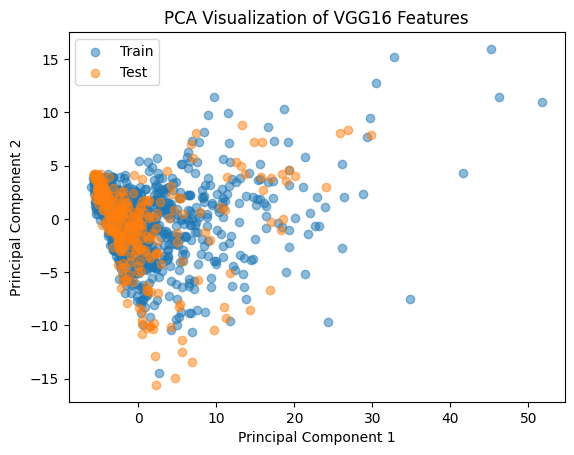

In [25]:
# Load the saved features
train_features = np.load('../vgg16_features_train.npy')
test_features = np.load('../vgg16_features_test.npy')

# Reshape the features to 2D
train_features_2d = train_features.reshape(train_features.shape[0], -1)
test_features_2d = test_features.reshape(test_features.shape[0], -1)

# Concatenate train and test features for PCA
all_features_2d = np.concatenate([train_features_2d, test_features_2d])

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(all_features_2d)

# Separate PCA results for train and test data
pca_train = pca_result[:len(train_features)]
pca_test = pca_result[len(train_features):]

# Plot PCA results
plt.scatter(pca_train[:, 0], pca_train[:, 1], label='Train', alpha=0.5)
plt.scatter(pca_test[:, 0], pca_test[:, 1], label='Test', alpha=0.5)
plt.title('PCA Visualization of VGG16 Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()